### Tasks

#### figure out a way to make the model deeper 
#### possibly look at different dataset - no overfitting - YearMSD
#### consider small model as low rank representation and project higher. (using outer product) train only small number of outer product parameters - https://arxiv.org/pdf/2012.13255.pdf

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [2]:
#Link to dataset: https://archive.ics.uci.edu/ml/datasets/DeliciousMIL%3A+A+Data+Set+for+Multi-Label+Multi-Instance+Learning+with+Instance+Labels#
import numpy as np
import pandas as pd
import re
def createDataset(path):
    file1 = open(path+"-data.dat", "r")
    file2 = open(path+"-label.dat", "r")
    dataset = []
    if (file1 and file2):
        split1 = file1.read().splitlines()
        split2 = file2.read().splitlines()
        for i, line in enumerate(split1):
            sentences = re.split('<\d*>', line)
            for sentence in sentences: 
                sentence = sentence.split(" ")
                while "" in sentence:
                    sentence.remove("")
                if len(sentence) > 0:
                    sentence += [0]*(10-len(sentence))
                    dataset.append(list(map(int, sentence)) + list(map(int, split2[i].split(" "))))
                    
        return dataset
                
    else:
        print("invalid field path")
            

In [3]:
dataset = pd.DataFrame(createDataset('Data/Delicious/train'))

In [4]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,6705,5997,8310,3606,674,8058,5044,4836,0,0,...,0,0,1,0,0,0,0,0,0,0
1,4312,5154,8310,4225,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1827,1037,8482,483,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3567,6172,6172,2892,1362,787,399,777,1332,0,...,0,0,0,0,0,1,0,0,0,0
4,318,769,4621,3199,1480,6213,971,6890,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149920,1386,384,4282,2229,5349,7139,5663,5742,4282,0,...,1,0,0,0,0,0,0,1,0,0
149921,6008,1758,5682,2263,7699,4700,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
149922,6072,1632,6587,2623,1178,6078,345,2651,0,0,...,0,0,0,0,0,0,0,0,0,0
149923,1281,3041,2797,6144,2276,5149,4621,1890,2276,5506,...,0,0,0,0,0,0,0,0,0,0


In [5]:
class Delicious(Dataset):
    def __init__(self, X, y, transform=False):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X.index)
    
    def __getitem__(self, index):
        sentence = self.X.iloc[index]
        label = self.y.iloc[index]
        target = np.zeros(8620)
        target[sentence] = 1

        if self.transform:
            sentence = torch.tensor(target, dtype=torch.float32)
            label = torch.tensor(label.values, dtype=torch.float32)
        
        if sentence.size(0) <= 0  or label.size(0) <= 0:
            print(index)
        
        else:
            return sentence, label

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = \
    train_test_split(dataset.loc[:, :9], dataset.loc[:, 10:], test_size=1/6, random_state=42)

print('train sentence shape : ', X_train.shape)
print('train label shape : ', y_train.shape)
print('valid sentence shape : ', X_valid.shape)
print('valid label image : ', y_valid.shape)

train sentence shape :  (124937, 10)
train label shape :  (124937, 20)
valid sentence shape :  (24988, 10)
valid label image :  (24988, 20)


In [7]:
train_dataset = Delicious(X=X_train, y=y_train, transform=True)
val_dataset = Delicious(X=X_valid, y=y_valid, transform=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [8]:
dataiter = iter(train_loader)
sentences, labels = next(dataiter)

print('sentences shape on PyTorch : ', sentences.size())
print('labels shape on PyTorch : ', labels.size())

sentences shape on PyTorch :  torch.Size([128, 8620])
labels shape on PyTorch :  torch.Size([128, 20])


In [9]:
from livelossplot import PlotLosses
from collections import defaultdict
device = torch.device("cuda")

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader,
                name):

  # Move the model and cost function to GPU (if needed).
  model = model.to(device)
  cost_function = cost_function.to(device)
  recordlogs = defaultdict(list)

  # Keep track of best accuracy so far.
  best_accuracy = 0 
  liveloss = PlotLosses()

  # Main for loop of SGD.
  for epoch in range(0, n_epochs):
    logs = {}

    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in training mode.
    model.train()

    # Sample a batch on each iteration.
    for (batch_id, (xb, yb)) in enumerate(train_loader):
      model.zero_grad()
      # Move (x,y) data to GPU (if so desired).
      xb = xb.to(device)
      yb = yb.to(device)

      # Compute predictions.
      #print("debug", xb.shape, yb.shape)#, predicted.shape)
      predicted = model(xb)
      
      # Compute loss.
      loss = cost_function(predicted, yb)
      cumulative_loss += loss.item()

      # Count how many correct in batch.
      predicted_ = predicted.detach().sigmoid()
      predicted_[(predicted<=0.5)] = 0
      predicted_[(predicted>0.5)] = 1
#       max_vals, max_ids = predicted_.max(dim = 1)
      correct += (predicted_ * yb).sum().cpu().item()
      n_samples += yb.sum().cpu().item()

      # Compute gradients (autograd).
      loss.backward()

      # Run one basic training step of SGD.
      optimizer.step()
      # This does basically the following operation.
      # for param in model.parameters():
      #    param.data -= learningRate * param.grad.data

      # Keep track of loss and accuracy for the plot.
      n_batches = 1 + batch_id 
      logs['loss'] = cumulative_loss / n_batches
      logs['accuracy'] = correct / n_samples
    
    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in evaluation mode.
    model.eval()

    # No need to keep track of gradients for this part.
    with torch.no_grad():
      # Run the model on the validation set to keep track of accuracy there.
      for (batch_id, (xb, yb)) in enumerate(val_loader):

        # Move data to GPU if needed.
        xb = xb.to(device)
        yb = yb.to(device)
    
        # Compute predictions.
        predicted = model(xb)

        # Compute loss.
        loss = cost_function(predicted, yb)
        cumulative_loss += loss.item()

        # Count how many correct in batch.
        predicted_ = predicted.detach().sigmoid()
#         max_vals, max_ids = predicted_.max(dim = 1)
        predicted_[(predicted<=0.5)] = 0
        predicted_[(predicted>0.5)] = 1
        correct += (predicted_*yb).sum().cpu().item()
        
        n_samples += yb.sum().cpu().item()

        # Keep track of loss and accuracy for the plot.
        n_batches = 1 + batch_id
        logs['val_loss'] = cumulative_loss / n_batches
        logs['val_accuracy'] = correct / n_samples

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'checkpoints/best_model_so_far_' + name + '.pth')

    # Update the plot with new logging information.
    liveloss.update(logs)
    liveloss.send()
    
    recordlogs['loss'].append(logs['loss'])
    recordlogs['accuracy'].append(logs['accuracy'])
    recordlogs['val_loss'].append(logs['val_loss'])
    recordlogs['val_accuracy'].append(logs['val_accuracy'])

    # What is this for? Please look it up.
    if scheduler != -1:
        scheduler.step()
        
  return recordlogs
  # Load the model parameters for the one that achieved the best val accuracy.
  # model.load_state_dict(torch.load('best_model_so_far.pth'))    

### Check the performance of small-sized model

In [10]:
class MLPSmall(nn.Module):
    def __init__(self):
        super(MLPSmall, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(8620, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 20)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [11]:
learningRate = 1e-4
modelSmall = MLPSmall()
optimizer = torch.optim.Adam(modelSmall.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(modelSmall)

MLPSmall(
  (layers): Sequential(
    (0): Linear(in_features=8620, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
)


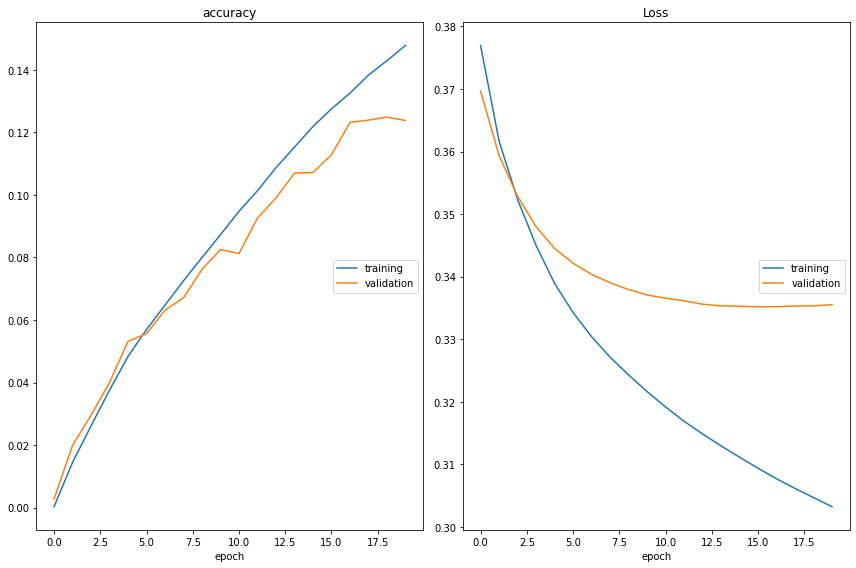

accuracy
	training         	 (min:    0.000, max:    0.148, cur:    0.148)
	validation       	 (min:    0.003, max:    0.125, cur:    0.124)
Loss
	training         	 (min:    0.303, max:    0.377, cur:    0.303)
	validation       	 (min:    0.335, max:    0.370, cur:    0.336)


In [13]:
small_logs = train_model(batch_size, n_epochs, learningRate, 
            modelSmall, cost_function, optimizer, -1, 
            train_loader, val_loader, name = 'small-delicious');

In [15]:
testDataset = pd.DataFrame(createDataset('Data/Delicious/test'))
testDataset

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,5282,4641,3031,536,5366,1759,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4855,1037,7752,2287,1090,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1921,6213,3292,5750,6068,5648,1444,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6157,1574,6955,2287,3816,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5553,568,6955,5523,2793,4312,2033,4217,7593,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73358,5978,3031,4466,483,3405,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73359,4466,4081,4621,474,5970,1259,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73360,1209,6858,1137,4466,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73361,859,444,1037,859,444,8482,4466,8482,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
def evaluateOnTest(model, testDataset):
    correct = 0
    nsamples = 0
    for index in range(len(testDataset)):
        output = np.zeros(8620)
        output[testDataset.loc[index, :9]] = 1
        pred = torch.sigmoid(model(torch.tensor(output, dtype=torch.float32, device = device)))
        
        pred[(pred<0.5)] = 0
        pred[(pred)>=0.5] = 1
        
        target = torch.tensor(testDataset.loc[index, 10:].values, dtype=torch.float32, device = device)
        
        correct += (pred*target).sum().item()
        nsamples += target.sum().item()
    
    return correct/nsamples

In [17]:
evaluateOnTest(modelSmall, testDataset)

0.19443747128505592

### Check the performance of medium-sized model

In [18]:
class MLPMedium(nn.Module):
    def __init__(self):
        super(MLPMedium, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(8620, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 20)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [19]:
learningRate = 1e-4
modelMedium = MLPMedium()
optimizer = torch.optim.Adam(modelMedium.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(modelMedium)

MLPMedium(
  (layers): Sequential(
    (0): Linear(in_features=8620, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=20, bias=True)
  )
)


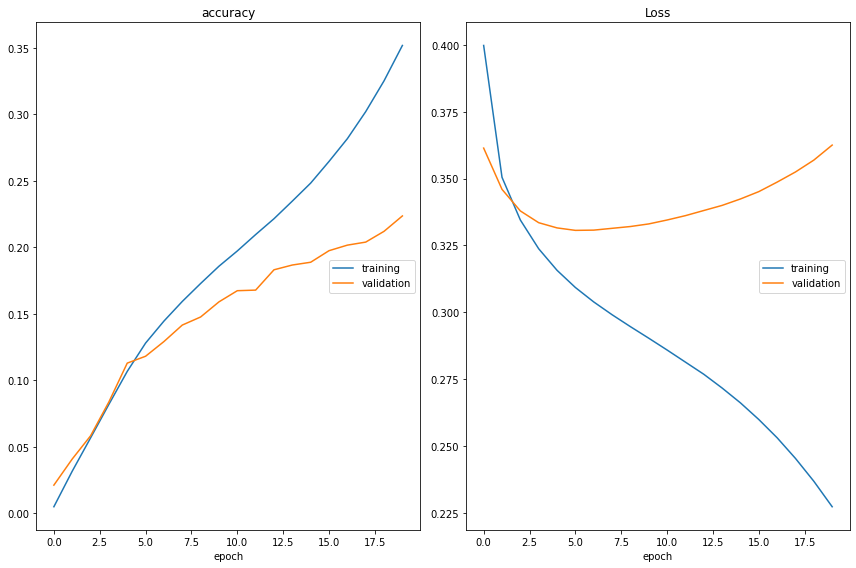

accuracy
	training         	 (min:    0.005, max:    0.352, cur:    0.352)
	validation       	 (min:    0.021, max:    0.224, cur:    0.224)
Loss
	training         	 (min:    0.227, max:    0.400, cur:    0.227)
	validation       	 (min:    0.331, max:    0.363, cur:    0.363)


In [20]:
medium_logs = train_model(batch_size, n_epochs, learningRate, 
            modelMedium, cost_function, optimizer, -1, 
            train_loader, val_loader, name = 'medium-delicious');

In [21]:
evaluateOnTest(modelMedium, testDataset)

0.25756535166037503

### Densify small model to the same parameters as the medium model

In [28]:
from scipy.stats import ortho_group
class MLPSmalltoMedium(nn.Module):
    def __init__(self, modelSmall):
        super(MLPSmalltoMedium, self).__init__()
        # extract weights from modelSmall
        self.layers = nn.Sequential(
            nn.Linear(8620, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 20)
        )
        
        for layer in range(len(modelSmall.layers)):
            try:
                tempWeight =  modelSmall.layers[layer].weight.data
                if layer != len(modelSmall.layers) - 1:
                    left = torch.tensor(np.delete(ortho_group.rvs(self.layers[layer].out_features), np.s_[modelSmall.layers[layer].out_features:], 1), device=device, dtype=torch.float32)
#                     print("left: " + str(left.size()), "current: " + str(tempWeight.size()))
                    tempWeight = torch.matmul(left, tempWeight)
                if layer != 0:
                    right = torch.tensor(np.delete(ortho_group.rvs(self.layers[layer].in_features), np.s_[modelSmall.layers[layer].in_features:], 1), device=device, dtype=torch.float32)
#                     print("current: " + str(tempWeight.size()), "right: " + str(right.T.size()))
                    tempWeight = torch.matmul(tempWeight, right.T)
                
                self.layers[layer].weight.data = tempWeight
                
            
            except Exception as e:
                print("Layer " + str(layer) + ": " + str(e))
                
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [29]:
bestSmallModel = MLPSmall()
bestSmallModel.load_state_dict(torch.load('checkpoints/best_model_so_far_small-delicious.pth'))
bestSmallModel = bestSmallModel.to(device)
upscaledModel = MLPSmalltoMedium(bestSmallModel)

Layer 1: 'ReLU' object has no attribute 'weight'
Layer 3: 'ReLU' object has no attribute 'weight'


In [30]:
learningRate = 1e-4
optimizer = torch.optim.Adam(upscaledModel.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(upscaledModel)

MLPSmalltoMedium(
  (layers): Sequential(
    (0): Linear(in_features=8620, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=20, bias=True)
  )
)


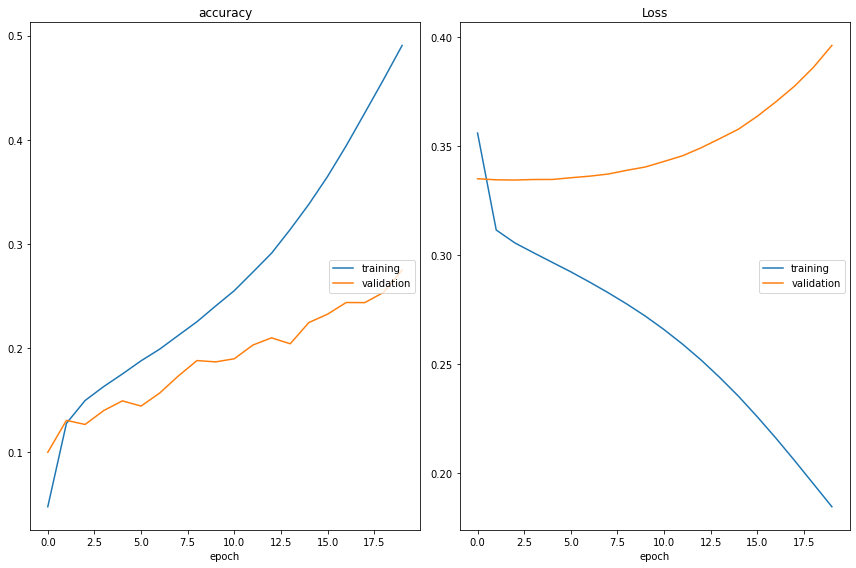

accuracy
	training         	 (min:    0.048, max:    0.491, cur:    0.491)
	validation       	 (min:    0.100, max:    0.275, cur:    0.275)
Loss
	training         	 (min:    0.185, max:    0.356, cur:    0.185)
	validation       	 (min:    0.334, max:    0.396, cur:    0.396)


In [31]:
upscaled_logs = train_model(batch_size, n_epochs, learningRate, 
            upscaledModel, cost_function, optimizer, -1, 
            train_loader, val_loader, name = "upscaled-delicious");

In [32]:
evaluateOnTest(upscaledModel, testDataset)

0.2928947979178409

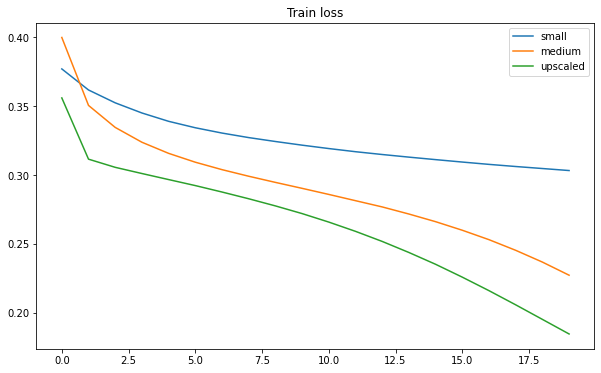

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['loss'])
plt.plot(medium_logs['loss'])
plt.plot(upscaled_logs['loss'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Train loss")

plt.show()

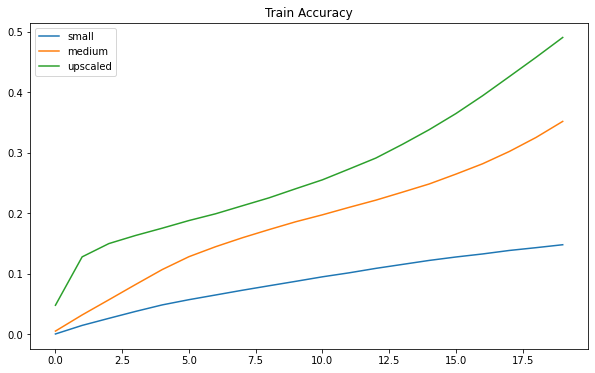

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['accuracy'])
plt.plot(medium_logs['accuracy'])
plt.plot(upscaled_logs['accuracy'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Train Accuracy")
plt.show()

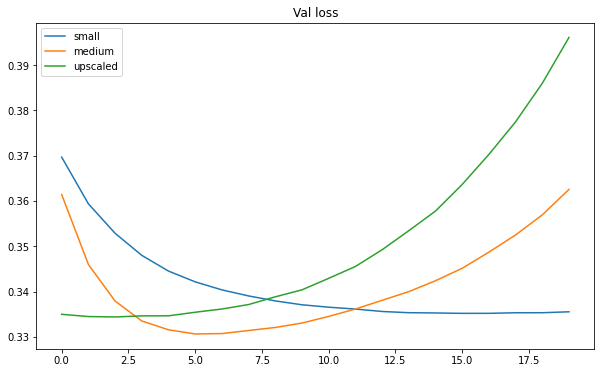

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['val_loss'])
plt.plot(medium_logs['val_loss'])
plt.plot(upscaled_logs['val_loss'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Val loss")

plt.show()

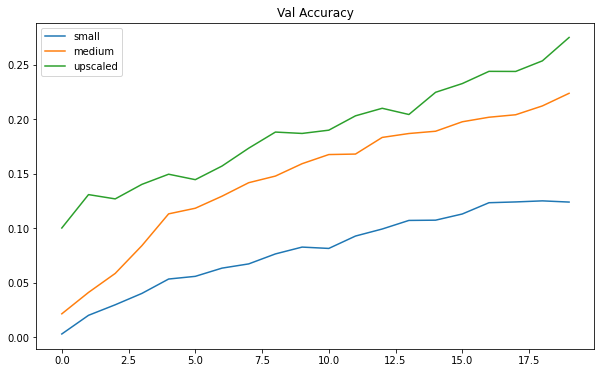

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['val_accuracy'])
plt.plot(medium_logs['val_accuracy'])
plt.plot(upscaled_logs['val_accuracy'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Val Accuracy")
plt.show()